In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.vgg16 import  VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import warnings
import os
import pickle
import time
import json
import cv2
import re
import string
import unicodedata
from sklearn.utils import shuffle
from tqdm import tqdm
warnings.filterwarnings(action = "ignore")

In [ ]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip",
                                          extract = True)
  os.remove(annotation_zip)

image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",
                                      extract = True)
  os.remove(image_zip)

1115422720/1115419746 [==============================] - 24s 0us/step


In [ ]:
text_path = "/content/Flickr8k.token.txt"
images_path = "/content/Flicker8k_Dataset"

In [ ]:
text = ""
with open(text_path) as file:
  text = file.read()

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

image_captions = load_descriptions(text)

In [ ]:
def clean(lang):
    pattern_ = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('','',string.punctuation)
    lang = unicodedata.normalize('NFD',lang).encode('ascii','ignore').decode('UTF-8')
    lang = lang.split()
    lang = [pattern_.sub('',word) for word in lang]
    lang = [word.lower() for word in lang]
    lang = [word.translate(table) for word in lang]
    lang = [word for word in lang if word.isalpha()]
    return ' '.join(lang)

In [ ]:
for item in image_captions:
  for i,lines in enumerate(image_captions[item]):
    image_captions[item][i] = clean(lines)      

In [ ]:
for key in image_captions.keys():
  image_captions[key] = '<start> ' + image_captions[key][0] + ' <end>'  

In [ ]:
# here i have not normalized the images cause i ran out of memory
vectors = {}
for image_names in os.listdir(images_path):
  image_id = image_names.split('.')[0]
  path = os.path.join(images_path,image_id + str(".jpg"))
  image = cv2.imread(path)
  image = cv2.resize(image,(224,224))
  image = np.asarray(image)
  try:
    vectors[image_id] = image
  except:
    pass

In [ ]:
cnn_model  = VGG16(include_top = False , weights="imagenet" )
cnn_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
for key in vectors.keys():
  vectors[key] = cnn_model(np.expand_dims(vectors[key],0))
  

In [ ]:
for key in vectors.keys():
  vectors[key] = np.reshape(vectors[key],(1,49,512))
filename = 'image_vectors'
outfile = open(filename,'wb')
pickle.dump(vectors,outfile)
outfile.close()

In [ ]:
input_tensor = []
target_tensor = []
for key in vectors.keys():
  if image_captions.get(key,None) is not None:
    target_tensor.append(image_captions.get(key))
    input_tensor.append(vectors[key])
  else:
    continue  
input_tensor = tf.concat(input_tensor,axis = 0)
target_tensor[0]

'<start> a group of college students walk in nice weather <end>'

In [ ]:
source_sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(target_tensor)
source_tensor = source_sentence_tokenizer.texts_to_sequences(target_tensor)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )
print("Max len of caption : "  + str(len(source_tensor[0])))
print("Source/Target shape : " + str(len(source_tensor)))
print("Source/Target shape : ",source_tensor.shape)
print("Shape input tensor : ",input_tensor.shape)

Max len of caption : 35
Source/Target shape : 8091
Source/Target shape :  (8091, 35)
Shape input tensor :  (8091, 49, 512)


In [ ]:
BATCH_SIZE = 100
embedding_dim = 256
vocab_size = len(source_sentence_tokenizer.word_index) + 1
units = 512
num_steps = len(input_tensor) // BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor,source_tensor))
dataset = dataset.batch(BATCH_SIZE)
print("Vocab size is : ",vocab_size)

Vocab size is :  4481


In [ ]:
# This encoder is for Neural Machine Translation and other purposes
class Encoder(tf.keras.Model):

  def __init__(self,dim,units,vocab_size):
    super(Encoder,self).__init__()
    self.dim = dim
    self.units = units
    self.vocab_size = vocab_size
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,self.dim)
    self.LSTM = tf.keras.layers.LSTM(self.units,return_sequences = True, return_state = True, recurrent_initializer='glorot_uniform') 

    def call(self,x,hidden):

      x = self.embeddding(x)
      x = self.LSTM(x,hiddden)  
      return x


  def init_hidden(self,batch):
     return (tf.zeros([batch,self.units]),tf.zeros([batch,self.units]))  


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer

    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class LoungAttention(tf.keras.layers.Layer):

  def __init__(self,units):
     super(LoungAttention,self).__init__()
     self.units = units
     self.ws = tf.keras.layers.Dense(self.units) 
     self.wc = tf.keras.layers.Dense(self.units) 
  
  def call(self,hidden,encoder_output):

    hidden = tf.expand_dims(hidden,axis = 1)
    score  = tf.matmul(hidden,self.ws(encoder_output),transpose_b = True)
    score = tf.nn.softmax(score,axis = 2)
    attention = tf.matmul(score,self.wc(encoder_output))
    return tf.squeeze(attention,axis = 1)
   

class Decoder(tf.keras.Model):

  def __init__(self,dim,units,vocab_size):
      super(Decoder,self).__init__()
      self.dim = dim
      self.units = units
      self.vocab_size = vocab_size
      self.embedding = tf.keras.layers.Embedding(self.vocab_size,self.dim)
      self.LSTM = tf.keras.layers.LSTM(self.units,return_sequences = True, return_state = True, recurrent_initializer='glorot_uniform') 
      self.attention_layer = LoungAttention(self.units)
      self.wc = tf.keras.layers.Dense(self.units, activation='tanh')
      self.ws = tf.keras.layers.Dense(self.vocab_size)

  def call(self,x,hidden,encoder_output):

    x = self.embedding(x)
    lstm_out, state_h, state_c = self.LSTM(x, initial_state = hidden)
  
    context_vector = self.attention_layer(state_h,encoder_output) # batch,units
    output = tf.concat([tf.squeeze(lstm_out,axis = 1),context_vector],axis = -1)
    output = self.wc(output)
    output = self.ws(output)
    return output,state_h,state_c

  def reset_state(self,batch):
    return (tf.zeros([batch,self.units]),tf.zeros([batch,self.units]))  


In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch = target.shape[0])
  decoder_input = tf.expand_dims([source_sentence_tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      encoder_output = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          decoder_output = decoder(decoder_input,hidden,encoder_output)
          hidden = decoder_output[1:]
          loss += loss_function(target[:, i], decoder_output[0])
          decoder_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
c/

In [ ]:
"""EPOCHS = 100
loss_plot = []
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset.take(-1)):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))"""

Epoch 1 Loss 1.755620
Time taken for 1 epoch 12.623716831207275 sec

Epoch 2 Loss 1.708492
Time taken for 1 epoch 12.48074221611023 sec

Epoch 3 Loss 1.681631
Time taken for 1 epoch 12.469922542572021 sec

Epoch 4 Loss 1.641180
Time taken for 1 epoch 12.45289158821106 sec

Epoch 5 Loss 1.570204
Time taken for 1 epoch 12.476596355438232 sec

Epoch 6 Loss 1.480142
Time taken for 1 epoch 12.584820985794067 sec

Epoch 7 Loss 1.386377
Time taken for 1 epoch 12.479850769042969 sec

Epoch 8 Loss 1.306499
Time taken for 1 epoch 12.54543924331665 sec

Epoch 9 Loss 1.249379
Time taken for 1 epoch 12.479151487350464 sec

Epoch 10 Loss 1.212836
Time taken for 1 epoch 12.382791996002197 sec

Epoch 11 Loss 1.173516
Time taken for 1 epoch 12.566399574279785 sec

Epoch 12 Loss 1.135935
Time taken for 1 epoch 12.430074453353882 sec

Epoch 13 Loss 1.105762
Time taken for 1 epoch 12.391925573348999 sec

Epoch 14 Loss 1.076325
Time taken for 1 epoch 12.442643165588379 sec

Epoch 15 Loss 1.056599
Time take

In [ ]:
encoder.save_weights('encoder_Loung.h5')
decoder.save_weights('decoder_Loung.h5')

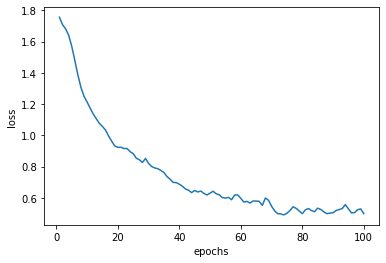

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,EPOCHS+1,1),loss_plot)
plt.xlabel('epochs')
plt.ylabel('loss');